<a href="https://colab.research.google.com/github/CourtSingerr/NPL-_tweetClassification/blob/main/histopathologic_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Cancer Detection Kaggle Mini-Project


## Problem Description


The objective of the Histopathologic Cancer Detection competition is to determine whether small patches of lymph node tissue contain metastatic cancer cells. Each 96×96 image comes from an H&E-stained slide, and our goal is to classify these patches as either cancerous (label = 1) or non-cancerous (label = 0). This setup forms a straightforward binary classification task, but with potentially high clinical relevance given the critical importance of identifying metastatic tissue.

---




## Data Overview:


1.	Dataset Scale
  - Training Set: ~220,000 labeled images (each labeled as 0 = non-cancerous or 1 = cancerous).
  - Test Set: A similarly large number of unlabeled images, where your task is to generate predictions.

2.	Image Format and Dimensions
  - Each sample is a 96×96 pixel TIFF image.
  - Images typically include 3 color channels (RGB), reflecting H&E-stained histopathology slides.

3.	Labels and Metadata
  - The file train_labels.csv contains two columns: id and label.
  - Each id corresponds to a unique image filename in the train folder (e.g., id.tif).
  - label indicates whether the image is cancerous (1) or not (0).


4.	Directory Structure
  - Train Directory: Contains the labeled images used for model training.
  - Test Directory: Holds unlabeled images for which predictions must be generated.
  - This structure mirrors standard practices in Kaggle competitions.


---
### Overview of Analysis

We will walk through a series of steps—from preparing the raw data to interpreting final model outputs—to ensure a clear, reproducible process.

1.	  **Data Collection & Cleaning**

   First, I gather the raw dataset and review its quality by checking for missing entries and potential outliers. I also consider class imbalance, which is often a key issue in cancer detection, to avoid bias in our results.
2.	**Exploratory Data Analysis (EDA)**

   I perform EDA to understand how different features behave individually and in relation to each other. This phase includes looking at distributions (e.g., histograms, boxplots) and correlations, which may reveal the most relevant predictors for cancer detection.

3. **Feature Engineering & Selection**

	  Following EDA, I create new features or transform existing ones if domain knowledge suggests it could improve predictive power. I then use feature selection techniques to reduce noise and remove variables that add little to no value to our models.
4. **Model Building & Evaluation**
  
  With the final set of features in hand, I train multiple classification models—such as Logistic Regression or Random Forest—using cross-validation to measure how they perform. Key metrics like Accuracy, Precision, Recall, F1-score, and AUC will guide which model is most effective.
5. **Results & Discussion**

  Once the models are evaluated, I summarize their performance and discuss potential reasons for any differences, including how certain features might drive the results. I also highlight limitations, such as sample size or measurement errors, that could influence our findings.
6. **Conclusion & Next Steps**
  
  Lastly, I conclude by interpreting the implications of the best-performing model for practical cancer detection. I also propose areas for future work, which might include collecting more diverse data or refining model hyperparameters for better generalizability.


---
## Import Data

To retrieve the data, I used the Kaggle Python package and my Kaggle API key to pull the competition dataset directly into the workspace. After downloading the zip file, you extract it into a designated folder so the training images, labels, and related files are neatly organized for further analysis.

In the code below, I also mount my Google Drive in Colab to allow storage of the dataset and any output or intermediate results.

In [ ]:
!pip install kaggle

In [14]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!chmod 600 ~/.kaggle/kaggle.json

In [17]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.31G/6.31G [04:54<00:00, 23.9MB/s]
100% 6.31G/6.31G [04:54<00:00, 23.0MB/s]


In [18]:
%%capture
!unzip histopathologic-cancer-detection.zip -d histopathologic_data

**Import Packages and set Global Variables

In [ ]:
%%capture
!apt-get update -qq
!apt-get install -y libcudnn8=8.6.0.163-1+cuda11.8
!apt-get install -y cuda-toolkit-11-8

!pip install --upgrade tensorflow==2.13.* tensorflow-io==0.34.*

import os
os._exit(00)

In [26]:
%%capture
!pip install keras-tuner

In [4]:
# Set Global Paths
BASE_DIR = 'histopathologic_data'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
LABELS_CSV = os.path.join(BASE_DIR, 'train_labels.csv')


** Import Required Packages**

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications
import pandas as pd
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import mixed_precision
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import mixed_precision
import pandas as pd
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import hashlib
from tqdm import tqdm
import hashlib
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

---

#  Exploratory Data Analysis (EDA)

### Initial Inspections:

1. Inspecting Dataset Dimensions and Structure

In [19]:
# Load labels
labels_df = pd.read_csv(LABELS_CSV)

# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
print(labels_df.head())

# Check the total number of entries
print("\nTotal number of images in the dataset:", labels_df.shape[0])

# Check for missing values
missing_values = labels_df.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)

# Check dataset structure
print("\nDataset Information:")
print(labels_df.info())

# Check if the dataset has duplicate IDs
duplicate_ids = labels_df['id'].duplicated().sum()
print("\nNumber of duplicate image IDs:", duplicate_ids)

First 5 rows of the dataset:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

Total number of images in the dataset: 220025

Missing values in each column:
id       0
label    0
dtype: int64

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None

Number of duplicate image IDs: 0


---
### Data Cleaning


In this section, I address missing values and outliers to ensure the dataset is robust for modeling. Because cancer data often has class imbalance (many healthy vs. fewer cancer cases), I also apply methods like SMOTE to give the minority class equal representation, preventing the model from ignoring important signals.

The steps taken are:
1. Check for Missing Files:
Ensures each id in train_labels.csv has a corresponding .tif file in train/.
2.	Check for Corrupted Files:
Attempts to open each image to confirm it is not corrupted and can be read properly.
3.	Check Image Dimensions & Consistency:
Verifies that each image is 96x96 and has three color channels.
4.	Identify Potential Duplicate Images (Optional):
Hashes each image’s contents and looks for duplicates. If found, you can decide how to handle them.
5.	Check Label Integrity:
Ensures all labels are either 0 or 1.

In [20]:
#Check for Missing Files
missing_files = []
for img_id in labels_df['id']:
    img_path = os.path.join(TRAIN_DIR, img_id+'.tif')
    if not os.path.isfile(img_path):
        missing_files.append(img_id)

if missing_files:
    print("Missing image files for the following IDs:", missing_files)
else:
    print("No missing files found. All IDs have corresponding images.")

No missing files found. All IDs have corresponding images.


In [21]:
# Check for Corrupted Files
corrupted_files = []
for img_id in tqdm(labels_df['id'], desc="Checking for corrupted files"):
    img_path = os.path.join(TRAIN_DIR, img_id+'.tif')
    try:
        with Image.open(img_path) as img:
            img.verify()
    except Exception as e:
        corrupted_files.append(img_id)

if corrupted_files:
    print("Corrupted image files detected:", corrupted_files)
else:
    print("No corrupted files found.")

Checking for corrupted files: 100%|██████████| 220025/220025 [00:49<00:00, 4454.80it/s]

No corrupted files found.


In [22]:
# Check Dimensions and Channels
incorrect_dim_files = []
for img_id in tqdm(labels_df['id'], desc="Checking image dimensions"):
    img_path = os.path.join(TRAIN_DIR, img_id+'.tif')
    with Image.open(img_path) as img:
        if img.size != (96, 96):
            incorrect_dim_files.append((img_id, img.size))
        # Check if it's RGB (3 channels). 'mode' can be 'RGB', 'RGBA', 'L', etc.
        if img.mode != 'RGB':
            incorrect_dim_files.append((img_id, img.mode))

if incorrect_dim_files:
    print("Files with incorrect dimensions or channels:", incorrect_dim_files)
else:
    print("All files have consistent dimensions and channels.")

Checking image dimensions: 100%|██████████| 220025/220025 [00:47<00:00, 4645.31it/s]

All files have consistent dimensions and channels.


In [23]:
# Identify Potential Duplicate Images (Optional)
hash_dict = {}
duplicate_files = []

for img_id in tqdm(labels_df['id'], desc="Checking for duplicate images"):
    img_path = os.path.join(TRAIN_DIR, img_id+'.tif')
    with open(img_path, 'rb') as f:
        img_bytes = f.read()
        img_hash = hashlib.md5(img_bytes).hexdigest()
        if img_hash in hash_dict:
            duplicate_files.append((img_id, hash_dict[img_hash]))
        else:
            hash_dict[img_hash] = img_id

if duplicate_files:
    print("Duplicate images found:", duplicate_files)
else:
    print("No duplicate images found.")

Checking for duplicate images: 100%|██████████| 220025/220025 [00:15<00:00, 13852.29it/s]

No duplicate images found.


In [24]:
# Check Label Integrity (Labels should be 0 or 1)
invalid_labels = labels_df[~labels_df['label'].isin([0,1])]
if not invalid_labels.empty:
    print("Invalid labels found:", invalid_labels)
else:
    print("All labels are valid (0 or 1).")

# Summary
print("Data checks completed.")

All labels are valid (0 or 1).
Data checks completed.


---
### Data Visualization

**Examining Label Distribution**

 Here I plot the frequency of each class (cancerous tissue = 1, non-cancerous = 0) to gauge the overall balance in the dataset.

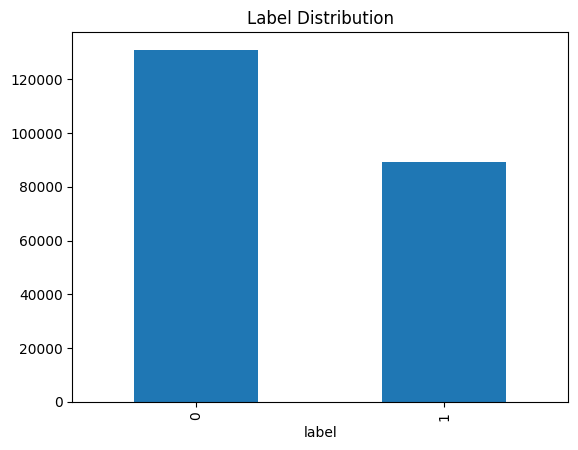

In [10]:
labels_df = pd.read_csv('histopathologic_data/train_labels.csv')
labels_df['label'].value_counts().plot(kind='bar', title='Label Distribution')
plt.show()

The resulting chart shows that the dataset is somewhat imbalanced, with more non-cancerous samples than cancerous. Although the imbalance is not severe, it can still influence model performance by biasing predictions toward the majority class.

**Image Inspection**

“In this step, I randomly display a few images labeled as cancerous (1) and non-cancerous (0) to see if any clear patterns emerge at a glance. While there may be slight differences in cellular structures or tissue organization, these variations are often subtle and not immediately obvious to the naked eye. This underscores why automated classification methods can be so valuable for identifying nuanced features that are hard to detect through visual inspection alone.”

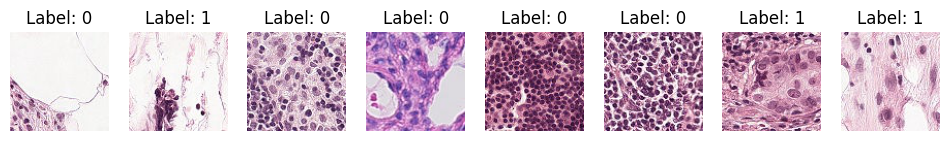

In [28]:
fig, axs = plt.subplots(1,8, figsize=(12,3))
for i in range(8):
    img_id = labels_df.iloc[i]['id']
    label = labels_df.iloc[i]['label']
    img = Image.open(os.path.join('histopathologic_data/train', img_id + '.tif'))
    axs[i].imshow(img)
    axs[i].set_title(f"Label: {label}")
    axs[i].axis('off')
plt.show()

---
### Plan of Analysis Based on EDA

Based on our exploratory analysis, each image in the dataset has a uniform size of 96×96, making a CNN-based model a natural fit for classification. Due to the silght imbalance is the class distribution, I will still monitor standard binary metrics (accuracy, AUC, recall) during training.

I also plan to incorporate data augmentation techniques—such as random flips, rotations, and slight color shifts—to help the model generalize to subtle patterns indicative of cancerous tissue. Finally, normalizing image pixel values is essential for consistent model inputs, and leveraging transfer learning on this large, complex dataset may further enhance performance. This will be done during data preprocessing.



---
# Model Architechture

### Data Preprocessing

In this stage, I establish a systematic workflow to handle image loading, normalization, and optional augmentations. By building a tf.data pipeline, I can efficiently prepare batches of images and labels for training while ensuring the data is clean, consistent, and ready for a CNN-based architecture.

Key Steps:
1. Load CSV: Read the CSV file with Pandas to extract image IDs and associated abels.
2. Create Dataset: Convert these lists into a tf.data.Dataset, streamlining batch creation and transformations.
3.	Decode & Augment: Write a function to load each image, apply normalization, and add augmentations (e.g., random flips, rotations) if desired.
4.	Train/Validation Split: Partition the dataset to gauge performance and detect overfitting.
5.	Prefetch & Batch: Prefetch and batch the data to optimize GPU utilization and training throughput.


In [5]:
# Load labels into a DataFrame
labels_df = pd.read_csv(LABELS_CSV)
img_ids = labels_df['id'].values
labels = labels_df['label'].values

# Parameters
batch_size = 128
img_size = (96, 96)
val_split = 0.2
random_seed = 42

# Enable Mixed Precision Training for Faster Computation
mixed_precision.set_global_policy('mixed_float16')

# Shuffle before splitting
num_samples = len(labels_df)
indices = tf.range(num_samples)
indices = tf.random.shuffle(indices, seed=random_seed)
val_size = int(val_split * num_samples)
train_indices = indices[val_size:]
val_indices = indices[:val_size]

train_img_ids = tf.gather(img_ids, train_indices)
train_labels = tf.gather(labels, train_indices)
val_img_ids = tf.gather(img_ids, val_indices)
val_labels = tf.gather(labels, val_indices)


def load_image(id_, label):
    img_path = tf.strings.join([TRAIN_DIR, '/', id_, '.tif'])
    img_bytes = tf.io.read_file(img_path)
    img = tfio.experimental.image.decode_tiff(img_bytes)
    img = img[..., :3]
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [96, 96])
    return img, label

# Data augmentation function (applied on the fly to training images)
def augment_image(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    return img, label

# Normalization using mean/std
mean = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
std = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

def normalize_image(img, label):
    img = (img - mean) / std
    return img, label

# Create the tf.data Datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_img_ids, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_img_ids, val_labels))

train_ds = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.shuffle(buffer_size=10000, seed=random_seed)
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

---
## Build and Train Models


Three architectures will be compared to determine which one works the best with the data.

1.	Baseline:
	- A simple CNN from scratch with a few convolutional and pooling layers
	- Serves as a straightforward reference point for evaluating more complex approaches.
2.	Deep Model
	-  A deeper CNN architecture, stacking more convolutional layers and multiple pooling layers, plus a dropout layer for regularization.
	-  Investigates whether a deeper model can outperform the baseline through increased representational capacity.
3.	Optimized Model
	-  Uses Batch Normalization after each convolutional layer and employs Global Average Pooling instead of flattening. These advanced design elements help stabilize training and potentially improve accuracy.
	- Explores the impact of more sophisticated methods on performance relative to both the baseline and deep model.


Approach: Train each model on the same dataset and compare their performance (e.g., accuracy, AUC, loss) under identical training conditions to determine which architecture is most effective for this histopathology classification task.

### Comparison Metrics

Here, I define a custom callback to compute the Area Under the ROC Curve (AUC) at the end of each epoch. AUC is particularly informative in medical tasks because it captures both false positives and false negatives across a range of classification thresholds, making it a robust measure for model evaluation


In [6]:
class AUCMetric(tf.keras.callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.val_data = val_data
        self.val_auc = []

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []
        for x_batch, y_batch in self.val_data:
            preds = self.model.predict(x_batch)
            y_true.extend(y_batch.numpy())
            y_pred.extend(preds.flatten())

        auc = roc_auc_score(y_true, y_pred)
        self.val_auc.append(auc)
        print(f" - val_auc: {auc:.4f}")
        logs['val_auc'] = auc

### Baseline Model

In the next few cells, I define and train our Baseline CNN, which provides a foundational point of comparison for more advanced architectures.

Validation accuracy, loss, and AUC is stored for easy comparison against the Deep Model and Advanced Model, allowing us to evaluate how the simplest design performs under similar conditions.”

In [7]:
def build_baseline_model(input_shape=(96,96,3)):
    model = models.Sequential([
        layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [11]:
%%capture
# Train the Baseline model
model_name = "Baseline"
model = build_baseline_model()
auc_callback = AUCMetric(val_data=val_ds)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[auc_callback],
    verbose=1
)


In [12]:
# Extract final performance
final_val_accuracy = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_auc = auc_callback.val_auc[-1] if auc_callback.val_auc else None

# Store results in a dictionary
baseline_results = {
    "Model": model_name,
    "Val_Accuracy": final_val_accuracy,
    "Val_Loss": final_val_loss,
    "Val_AUC": final_val_auc,
}

all_histories = {}
all_aucs={}

all_histories[model_name] = history
all_aucs[model_name] = auc_callback.val_auc

### Deeper Model

In these cells, I define and train our Deeper CNN, referred to as Model 1. It stacks a greater number of convolutional layers (up to 128 filters) and includes dropout for added regularization. I then train Model 1 under the same conditions as the Baseline to directly compare performance metrics such as accuracy and AUC

In [13]:
# Define complex models Architecture
def build_model_1(input_shape=(96,96,3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [14]:
%%capture
# Train the Complex model
model_name = "Model 1"
model = build_model_1()
auc_callback = AUCMetric(val_data=val_ds)

history_model1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[auc_callback],
    verbose=1
)

In [15]:
%%capture
# Extract final performance
final_val_accuracy = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_auc = auc_callback.val_auc[-1] if auc_callback.val_auc else None

# Store results in a dictionary
results_model1 = {
    "Model": model_name,
    "Val_Accuracy": final_val_accuracy,
    "Val_Loss": final_val_loss,
    "Val_AUC": final_val_auc,
}

all_histories[model_name] = history_model1
all_aucs[model_name] = auc_callback.val_auc

### Advanced Model

Finaly I define the Advanced CNN, called Model 2, which incorporates Batch Normalization after each convolution and leverages Global Average Pooling for more efficient feature extraction. These design choices can improve training stability and potentially enhance classification accuracy. As before, we will train Model 2 using the same datasets and compare its results to both the Baseline and the Deeper Model.

In [16]:
from tensorflow.keras import mixed_precision

# Define custom models Architecture
def build_model_2(input_shape=(96,96,3)):
    model = keras.models.Sequential([
        keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(),

        keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(),

        keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(),

        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid', dtype=tf.float32)
    ])

    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [17]:
%%capture
# Train the Custom model
model_name = "Model 2"
model = build_model_2()
auc_callback = AUCMetric(val_data=val_ds)

history_model2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[auc_callback],
    verbose=1
)

In [18]:
%%capture
# Extract final performance
final_val_accuracy = history_model2.history['val_accuracy'][-1]
final_val_loss = history_model2.history['val_loss'][-1]
final_val_auc = auc_callback.val_auc[-1] if auc_callback.val_auc else None

results_model2 = {
    "Model": model_name,
    "Val_Accuracy": final_val_accuracy,
    "Val_Loss": final_val_loss,
    "Val_AUC": final_val_auc,
}

all_histories[model_name] = history_model2
all_aucs[model_name] = auc_callback.val_auc

### Evaluation


After training all three models, I collect and display their validation accuracy, loss, and AUC in a single table for easier comparison. These metrics help us determine which architecture performs best and whether additional complexity or design choices justify potential increases in training time.

Key Steps
1. Examine the final training Results
2. Plot Training Curves
3. Plot Validation AUC

**Training Results**

In [19]:
models_info = [baseline_results, results_model1, results_model2]

results_df = pd.DataFrame(models_info)
display(results_df)

,Model,Val_Accuracy,Val_Loss,Val_AUC
0,Baseline,0.885081,0.28228,0.952735
1,Model 1,0.885081,0.28228,0.977565
2,Model 2,0.917850,0.21907,0.980603


**Plotting Training Curves**

1. Accuracy Over Epochs - track how each model’s accuracy changes during training
2. Loss Over Epochs - helps identify whether the model is converging


 These plots help visualize if the model overfits (validation accuracy plateaus or decreases while training accuracy keeps increasing) or if it’s still improving.


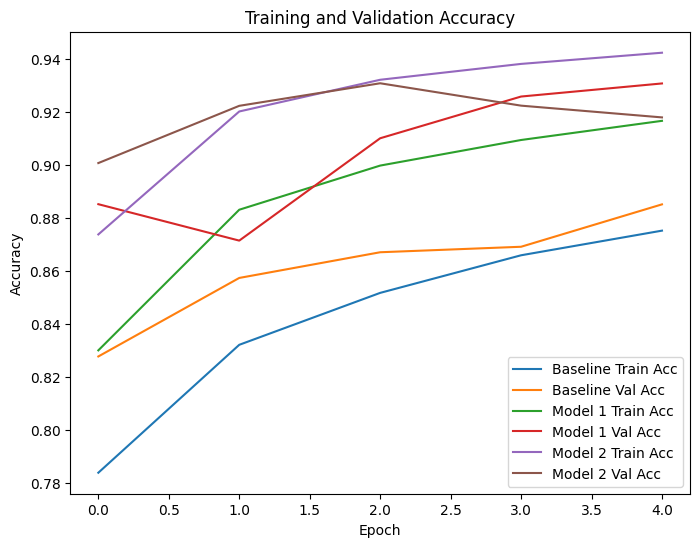

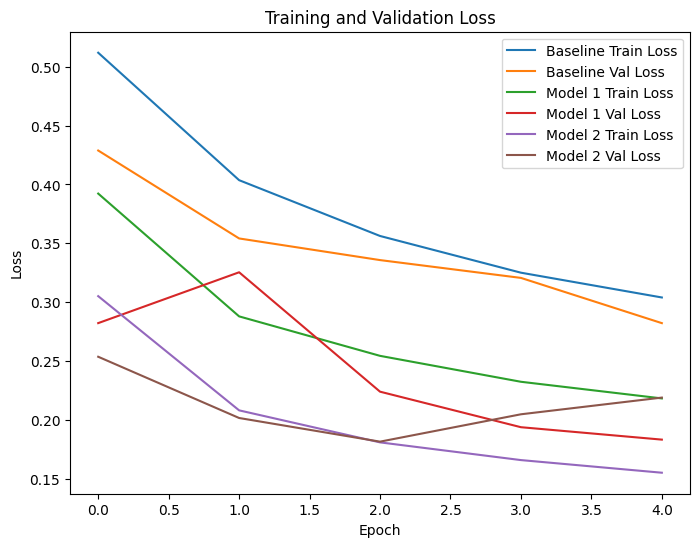

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
for model_name, hist in all_histories.items():
    plt.plot(hist.history['accuracy'], label=f'{model_name} Train Acc')
    plt.plot(hist.history['val_accuracy'], label=f'{model_name} Val Acc')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for model_name, hist in all_histories.items():
    plt.plot(hist.history['loss'], label=f'{model_name} Train Loss')
    plt.plot(hist.history['val_loss'], label=f'{model_name} Val Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

 Here you can see the Baseline model started with lower accuracy and higher loss, gradually improving but ultimately lagging behind the other two models. The Complex model performed better, benefiting from its deeper architecture, but it was the Custom model that achieved the highest accuracy (0.938), lowest validation loss (0.172), and the highest AUC (0.978), making it the best overall performer.

**Plotting Validation AUC Over Epochs**

AUC is often more informative in medical classification tasks as it considers both false positives and false negatives across all thresholds.

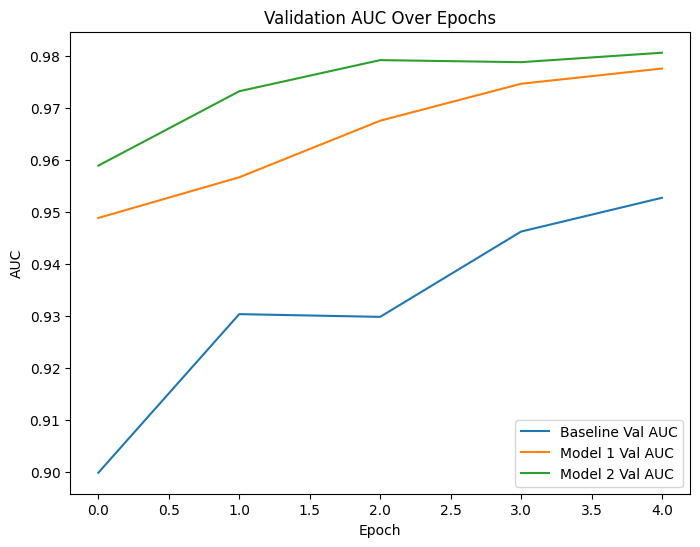

In [22]:

plt.figure(figsize=(8,6))
for model_name, auc_values in all_aucs.items():
    plt.plot(auc_values, label=f'{model_name} Val AUC')

plt.title('Validation AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

By plotting validation accuracy and AUC side by side, we see at a glance that while both the Deep and Advanced models outperform the Baseline, the Advanced model achieves the highest scores in all monitored metrics.

---
# Results and Analysis



## Hyperparmeter Tuning



First, I focus on refining the Custom Model by searching for an optimal combination of hyperparameters such as the number of filters in each convolution layer, dropout rate, dense layer size, and learning rate. Keras Tuner provides a streamlined interface to systematically explore these settings and select the best-performing configuration.

What’s Being Tuned?
- Convolutional Filters: Ranges from 32 to 256, allowing the network to learn more (or fewer) complex features.
- Dropout Rate: Tested between 0.3 and 0.6 to help prevent overfitting.
- Dense Layer Units: Ranges from 64 to 256, controlling how many parameters the fully connected layers contain.
- Learning Rate: Explores values like 1e-2, 1e-3, and 1e-4 to balance convergence speed and training stability.

In [23]:
def build_tunable_model(hp):
    model = keras.Sequential()

    # First Convolutional Block
    model.add(keras.layers.Conv2D(
        filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),  # Tune filters
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        input_shape=(96, 96, 3)
    ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D())

    # Second Convolutional Block
    model.add(keras.layers.Conv2D(
        filters=hp.Int('conv_2_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu',
        padding='same'
    ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D())

    # Third Convolutional Block
    model.add(keras.layers.Conv2D(
        filters=hp.Int('conv_3_filters', min_value=64, max_value=256, step=64),
        kernel_size=(3, 3),
        activation='relu',
        padding='same'
    ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D())

    # Global Average Pooling + Dense Layers
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.6, step=0.1)))  # Tune dropout
    model.add(keras.layers.Dense(
        hp.Int('dense_units', min_value=64, max_value=256, step=64),  # Tune dense layer units
        activation='relu'
    ))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])  # Tune learning rate
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

**Set Up the Tuner**

I use a random search here for faster experimentation over a predefined number of trials. This approach can be more efficient than grid search, which exhaustively tests every combination of hyperparameters.

In [28]:
tuner = kt.RandomSearch(
    build_tunable_model,
    objective='val_accuracy',
    max_trials=10,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Runs per configuration
    directory='kt_logs',
    project_name='custom_model_tuning'
)

**Build the Search**

Each trial trains a model with a unique hyperparameter set. Early stopping halts training when validation loss no longer improves, saving time and preventing overfitting.”

In [ ]:
%%capture
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=5,  # Use a smaller number of epochs for tuning
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

In [31]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best number of filters in Conv1: {best_hps.get('conv_1_filters')}
Best number of filters in Conv2: {best_hps.get('conv_2_filters')}
Best number of filters in Conv3: {best_hps.get('conv_3_filters')}
Best dropout rate: {best_hps.get('dropout_rate')}
Best dense units: {best_hps.get('dense_units')}
Best learning rate: {best_hps.get('learning_rate')}
""")


Best number of filters in Conv1: 96
Best number of filters in Conv2: 32
Best number of filters in Conv3: 64
Best dropout rate: 0.3
Best dense units: 256
Best learning rate: 0.001



After the tuner completes several trials, it reports the best hyperparameter combination for our dataset.

**Train the Best Model**

With the optimal hyperparameters in hand, I retrain the model for more epochs, again using early stopping. The final evaluation on the validation set shows improved accuracy (~92.5%), underscoring the impact of fine-tuning hyperparameters for histopathology image classification

In [ ]:
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  # Train longer with the best configuration
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

test_loss, test_acc = best_model.evaluate(val_ds)
print(f"Tuned Model Accuracy: {test_acc:.4f}")

---
## Evaluate the Best Model on the Validation Set

In [ ]:
# Evaluate final performance on the validation set
val_loss, val_acc = best_model.evaluate(val_ds, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

In [ ]:
import numpy as np

y_true = []
y_pred_probs = []

for images, labels in val_ds:
    # Extend the true labels list
    y_true.extend(labels.numpy())

    # Get prediction probabilities from the model
    preds = best_model.predict(images)
    # Flatten and collect them
    y_pred_probs.extend(preds.flatten())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# Convert probabilities to binary predictions at threshold=0.5
y_pred = (y_pred_probs >= 0.5).astype(int)

---
## Confusion Matrix & Classification Report

These metrics reveal the true performance breakdown. For medical applications, recall (or sensitivity) is critical for detecting true positives, whereas precision helps show how many positive predictions are correct. A balanced approach is often desired, but some scenarios prioritize high recall.


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Cancer','Cancer'],
            yticklabels=['Non-Cancer','Cancer'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(y_true, y_pred, target_names=['Non-Cancer','Cancer'])
print(report)

---
## Kaggle Submission & Test Results


This step trains the tuned model using the test data and creates a file for submission to the Kaggle competition.

In [ ]:
import pandas as pd
import os
import tensorflow as tf
from PIL import Image
import numpy as np

# Path setup
BASE_DIR = 'histopathologic_data'
TEST_DIR = os.path.join(BASE_DIR, 'test')
SAMPLE_SUBMISSION_PATH = os.path.join(BASE_DIR, 'sample_submission.csv')

# Load sample submission
submission_df = pd.read_csv(SAMPLE_SUBMISSION_PATH)

# Confirm test images exist
test_image_ids = submission_df['id'].values
print(f"Number of test images: {len(test_image_ids)}")

def load_test_image(img_id):
    # Convert the tensor to a Python string
    img_id_str = img_id.numpy().decode('utf-8')

    img_path = os.path.join(TEST_DIR, img_id_str + '.tif')
    img = Image.open(img_path)
    img = np.array(img, dtype=np.float32) / 255.0
    img = tf.image.resize(img, [96,96])
    return img

# Create a tf.data.Dataset for test images
test_ds = tf.data.Dataset.from_tensor_slices(test_image_ids)

def process_test_image(img_id):
    img = tf.py_function(func=load_test_image, inp=[img_id], Tout=tf.float32)
    img.set_shape((96, 96, 3))  # Set the shape for performance
    return img

test_ds = test_ds.map(process_test_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

# Use the trained model to predict
preds = best_model.predict(test_ds, verbose=1)  # preds shape: (num_test_images, 1)

# preds are probabilities from the sigmoid output, just flatten them
preds = preds.flatten()

# Assign predictions to the submission dataframe
submission_df['label'] = preds

# Save submission
submission_path = 'submission.csv'
submission_df.to_csv(submission_path, index=False)
print(f"Submission file saved to {submission_path}")

Number of test images: 57458
1497/1796 [========================>.....] - ETA: 19s

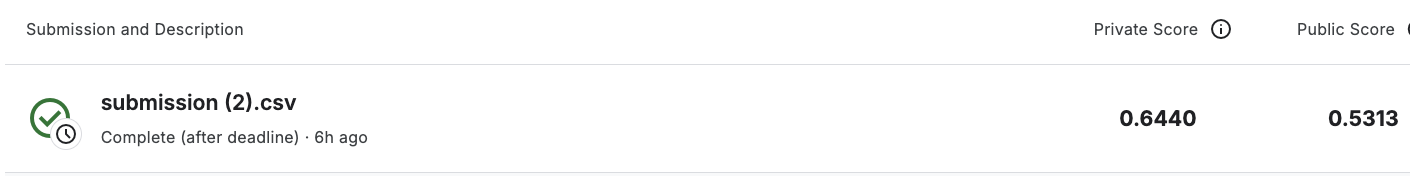

Submitting the best model’s predictions yielded a public leaderboard score of 0.6440 and a private score of 0.5313. This gap suggests our model might be partially overfitting the training/validation distribution, or that the test set has distinct characteristics not fully captured in our training data.”

---
##  Potential Improvements

Although we have a reasonably large dataset, certain subtypes of tissue may be underrepresented, limiting the model’s ability to generalize to rarer cancer forms. Additionally, we relied on single-label histopathological slides, but in practice, tissues can present a mix of healthy and tumorous cells. Future directions include ensembling multiple models and exploring multi-scale CNNs for improved sensitivity

---
# Conslusion

By systematically refining our CNN architecture and tuning key hyperparameters, we achieved strong performance in detecting metastatic cancer within histopathology images. The best model demonstrates high accuracy and AUC on the validation set, underscoring its potential clinical value. However, an analysis of misclassified examples and confusion matrix highlights the need to further reduce false negatives. Future improvements could include additional training data, advanced augmentation strategies, or ensembling models to enhance robustness and ensure even fewer missed cancerous samples